# COGS 108 - Final Project 

# Overview

There are many data points out there these days with regards to a restaurants quality. I try and take a look at the relationships between those quality ratings and neighborhood economic positions. Analyzing yelp ratings, health inspection scores, and average household income, I try to find any possible connections.

# Name & PID

- Name: Colin Wageman
- PID: A16090147

# Research Question

Does the average health inspection violations, median household income, and poverty percentage correlate with the average yelp review score for a given postal code?

## Background and Prior Work

Do different neighborhoods have cleaner restaurants? That was the question asked Mode[1]. They were able use New York City's open data system and associate average health inspection scores with zip codes. Using the latest inspection for each restaurant the were able to make a map of the cleanest places to eat in NYC. They also took it a step further and should which chains had the clear establishments.

Wondering if different neighborhoods have different levels of cleanly nice, I was curious if there was any less demand for restaurants in poorer neighborhoods and found that low income families and spend even more than middle income families on restaurant food [2]. This got me wondering if the demand allowed or made for an environment where health inspections scores were related to a neighborhoods income level and if that could also be seen in yelp ratings.

References (include links):
- 1) https://mode.com/blog/nyc-cleanest-restaurants/
- 2) https://www.ajc.com/business/consumer-advice/poor-spend-nearly-much-the-rich-restaurants/RCUDw6BEQdGLao4byjbO4M/

# Hypothesis


If average yelp scores are low, and resources in a neighborhood are low, then average health inspection violations will be high. Conversely, in yelp scores are high in postal code area with higher household incomes, and less overall poverty, then the average violations will be lower.

# Dataset(s)

- Dataset Name: Zipcodes
- Link to the dataset: 'zipcodes.csv'
- Number of observations: 38 zipcode

This dataset contains all the zipcodes in Wake County, NC. In include information such as median household income and percentage of families below the poverty line.

- Dataset Name: Restaurants
- Link to the dataset: 'restaurants.csv'
- Number of observations: 3324 restaurants

This data contains restaurants and their location information plus their health inspection ids.

- Dataset Name: Yelp
- Link to the dataset: 'yelp.csv'
- Number of observations: 3688 ratings

This data contains the ratings and attributes for the restaurants in the general area.

- Dataset Name: Inspections
- Link to the dataset: 'inspections.csv'
- Number of observations: 18466 inspection records

This contains inspection records over a multi year period. Has the number of non critical and critical violation for each inspection, plus the zip code of the establishment.

- Dataset Name: zip_geo
- Link to the dataset: 'Zip_Codes.shp'
- Description: Wake County zipcode shape file

This contains coordinated corresponding to each zipcodes boundaries.

I combine all the file by zipcode for my analysis. This allows for plotting maps and bar charts of the data based on zipcode.

# Setup

In [1]:
zip_csv = 'data/zipcodes.csv'
yelp_csv = 'data/yelp.csv'
inspections_csv = 'data/inspections.csv'
zip_shape_file = 'data/Zip_Codes.shp'

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm

# !pip install geopandas
# !pip install descartes
import geopandas as gpd

zips = pd.read_csv(zip_csv)
yelp = pd.read_csv(yelp_csv)
inspections = pd.read_csv(inspections_csv)
zip_geo = gpd.read_file(zip_shape_file)

# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# simplify postal codes and slim the number of columns to only what is needed.
inspections['zipcode'] = inspections['postalcode'].str[:5]
inspections = inspections[['zipcode', 'score', 'num_critical', 'num_non_critical', 'critical']]
inspections = inspections.groupby(['zipcode'], as_index = False).mean()
inspections['zipcode'] = inspections.zipcode.astype(int)
inspections.head()

,zipcode,score,num_critical,num_non_critical,critical
0,27501,94.750000,6.000000,4.000000,1.000000
1,27502,96.367223,2.972686,3.874052,0.861912
2,27511,96.418969,2.910381,5.626587,0.773712
3,27512,95.611111,3.111111,6.222222,0.777778
4,27513,95.655130,4.368356,7.175525,0.886279


In [3]:
yelp['zipcode'] = yelp['zip_code']
yelp = yelp[['rating', 'zipcode']]
yelp = yelp.groupby('zipcode', as_index = False).mean()
yelp['zipcode'] = yelp.zipcode.astype(int)
yelp.head()

,zipcode,rating
0,15035,1.00
1,22701,4.00
2,27023,3.75
3,27041,4.50
4,27203,4.00


In [4]:
zips = zips.rename(columns={'zip': 'zipcode','percent_damilies_below_poverty_line': 'below_poverty', 'median_household_income_dollars': 'avg_income', 'percent_nonwhite': 'nonwhite'})
zips = zips[['zipcode', 'below_poverty', 'avg_income', 'nonwhite']]
zips['zipcode'] = zips.zipcode.astype(int)
zips.head()

,zipcode,below_poverty,avg_income,nonwhite
0,27501,10.5,51121,17.9
1,27502,3.4,95857,18.9
2,27511,9.6,67392,24.8
3,27513,3.8,87262,27.8
4,27518,5.5,98247,19.9


In [5]:
# Make sure we are only using the zipcodes that we have demographic info for (drops about 14 zipcodes of 51)
inspections = inspections[inspections.zipcode.isin(zips.zipcode)]
yelp = yelp[yelp.zipcode.isin(zips.zipcode)]
print(inspections.shape, yelp.shape, zips.shape)

(37, 5) (38, 2) (38, 4)


In [6]:
# looks like there is a zipcode that is not in the inspections info
# What is it?
zips[~zips.zipcode.isin(inspections.zipcode)]

,zipcode,below_poverty,avg_income,nonwhite
37,27703,12.7,54674,61.5


In [7]:
# Looks like it is part of Wake County and Durham, lets remove that zipcode form the other datasets
zips = zips[zips.zipcode != 27703]
yelp = yelp[yelp.zipcode != 27703]
print(inspections.shape, yelp.shape, zips.shape)

(37, 5) (37, 2) (37, 4)


In [8]:
# combine to one dataset
df = zips.merge(yelp)
df = df.merge(inspections)
df.head()

,zipcode,below_poverty,avg_income,nonwhite,rating,score,num_critical,num_non_critical,critical
0,27501,10.5,51121,17.9,4.055556,94.750000,6.000000,4.000000,1.000000
1,27502,3.4,95857,18.9,3.610526,96.367223,2.972686,3.874052,0.861912
2,27511,9.6,67392,24.8,3.631841,96.418969,2.910381,5.626587,0.773712
3,27513,3.8,87262,27.8,3.707006,95.655130,4.368356,7.175525,0.886279
4,27518,5.5,98247,19.9,3.561856,97.225291,1.924419,4.174419,0.738372


In [9]:
# Geodata cleaning
zip_geo = zip_geo[zip_geo.ZIPNUM.notnull()]
zip_geo['zipcode'] = zip_geo.ZIPNUM.astype(int)

zip_geo = zip_geo.merge(df)

zip_geo.head()

,OBJECTID,ZIPNAME,ZIPNUM,ZIPCODE,NAME,SHAPEAREA,SHAPELEN,LAST_EDITE,geometry,zipcode,below_poverty,avg_income,nonwhite,rating,score,num_critical,num_non_critical,critical
0,4731,RALEIGH,27601.0,RALEIGH 27601,RALEIGH,5.075530e+07,43034.538745,None,"POLYGON ((2110911.905 734054.272, 2110909.498 ...",27601,35.9,27564,69.9,3.816547,96.023700,2.766055,4.058104,0.860856
1,4733,RALEIGH,27604.0,RALEIGH 27604,RALEIGH,5.678501e+08,201307.097948,None,"POLYGON ((2131220.755 746196.862, 2131224.716 ...",27604,14.4,50365,41.3,3.661972,95.510227,3.017045,6.135227,0.868182
2,4784,RALEIGH,27604.0,RALEIGH 27604,RALEIGH,3.421087e+00,16.380927,None,"POLYGON ((2124930.489 764609.165, 2124923.252 ...",27604,14.4,50365,41.3,3.661972,95.510227,3.017045,6.135227,0.868182
3,4734,WAKE FOREST,27587.0,WAKE FOREST 27587,WAKE FOREST,2.682918e+09,561034.849697,None,"POLYGON ((2095200.449 814685.490, 2095255.380 ...",27587,5.5,83416,18.0,3.798701,96.423409,2.307443,5.114347,0.804746
4,4740,WAKE FOREST,27587.0,WAKE FOREST 27587,WAKE FOREST,1.481934e-01,2.037362,None,"POLYGON ((2154266.084 783381.473, 2154265.557 ...",27587,5.5,83416,18.0,3.798701,96.423409,2.307443,5.114347,0.804746


# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [10]:
plt.rcParams['figure.figsize'] = (15, 5)

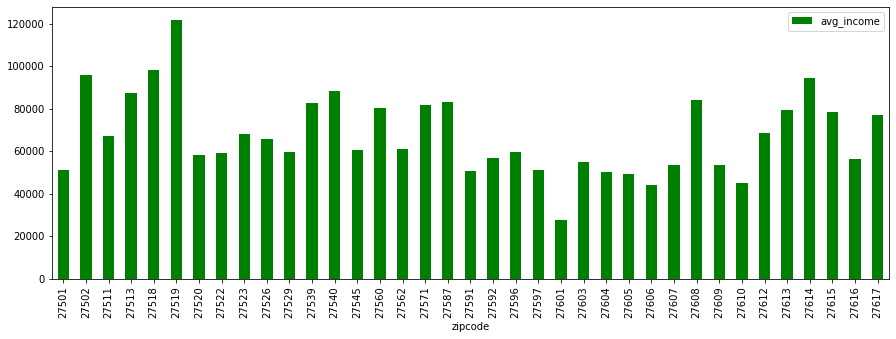

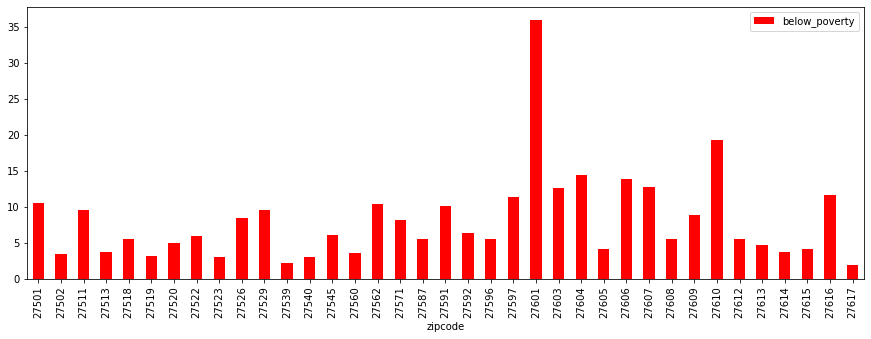

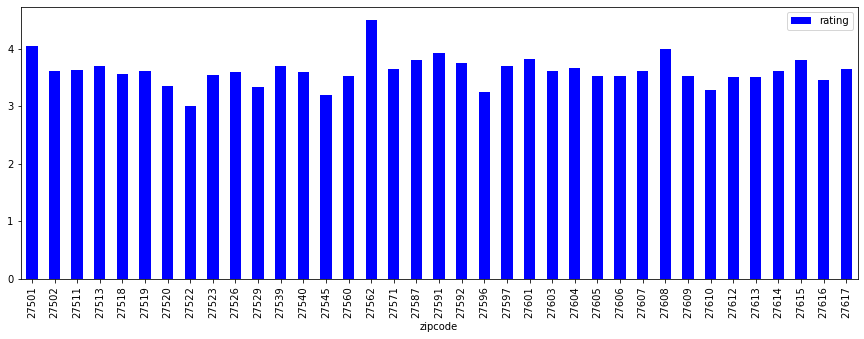

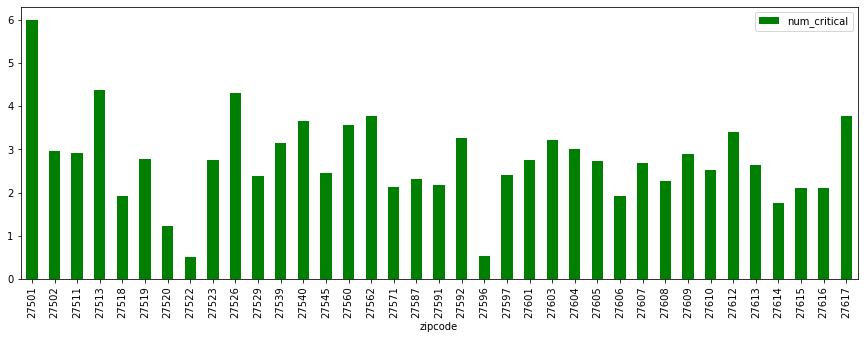

In [11]:
zips.plot.bar(x='zipcode',y='avg_income', color='green')
plt.show()
zips.plot.bar(x='zipcode',y='below_poverty', color='red')
plt.show()
yelp.plot.bar(x='zipcode',y='rating', color='blue')
plt.show()
inspections.plot.bar(x='zipcode',y='num_critical', color='green')
plt.show()

In [12]:
outcome, predictors = patsy.dmatrices('num_critical ~ rating + avg_income', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

In [13]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           num_critical   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     6.342
Date:                Wed, 10 Jun 2020   Prob (F-statistic):            0.00456
Time:                        23:41:49   Log-Likelihood:                -46.848
No. Observations:                  37   AIC:                             99.70
Df Residuals:                      34   BIC:                             104.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.6966      2.134     -2.201      0.0

In [14]:
plt.rcParams['figure.figsize'] = (7, 7)

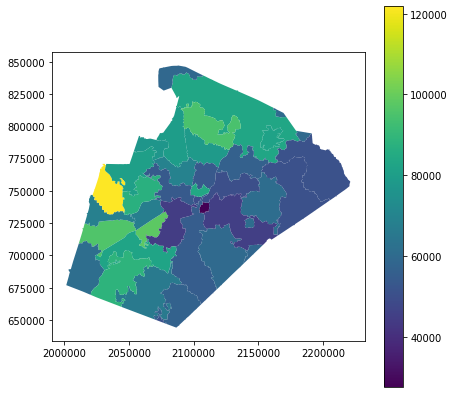

In [15]:
# plot of average income per zipcode
zip_geo.plot(column='avg_income', legend=True)

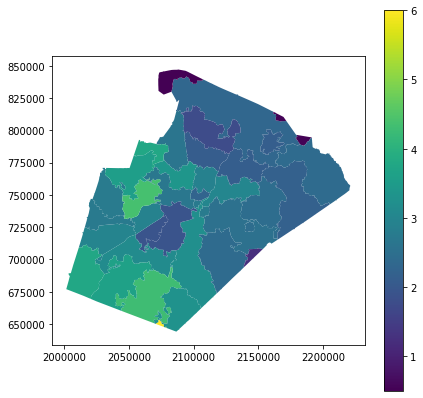

In [16]:
# plot of average number of critical violations per zipcode
zip_geo.plot(column='num_critical', legend=True)

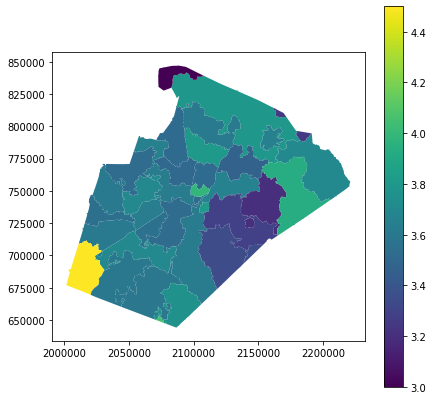

In [17]:
zip_geo.plot(column='rating', legend=True)

It would seem my hypothesis was wrong. There doesn't seem to be any correlation between average yelp ratings, average income, and food inspections scores in a neighborhood.

# Ethics & Privacy

The data originally had restaurant names, which could be a point of privacy concerns. Though restaurants are not people and both food inspection scores and yelp ratings are public. Regardless, the names of specific establishments were striped from the data for this analysis.
Ethics is where this type of analysis might become questionable. If we were an actual health inspection agent and we used demographic information to target specific demographic restaurants for further analysis, this might lead to scoring bias down the road. My data did not prove this, but lets say that a neighborhoods average wealth was correlated with restaurant inspection violations. You might use this information to crack down on restaurants in these targeted neighborhoods, but this may lead inspectors to initially think that a new restaurant that they haven't check before is likely to have violations and thus creating a higher level of scrutiny than inspections on establishments in better rated/scoring neighborhoods. If we were able to predict health inspection scores and found a neighborhood that was struggling to keep high scores, this tool should then be used to target restaurants that need support resources. Keeping inspection random and unbiased.

# Conclusion & Discussion

I found it challenging to think of creative uses for the data and focusing that data in on health inspections questions. With infinite time and data I think I would have like to use the different attributes as vectors and create a machine learning model that might be able to predict based on many more attributes than the 3 I chose to focus on. When I first went through the data I spent a lot of time trying to link individual restaurant health inspection scores to yelp reviews, but my efforts only matched around 700 restaurants out of the over 2000 I had access to. This left me with my question of whether yelp score and neighborhood wealth could be tied to health inspection scores. What I found was that they could not be tied together. I think I was generalizing the data too much by averaging everything to just the zipcodes.

I think it would be interesting to take this further and gather past yelp data, and more restaurant info and build maps and guides for future and current restaurants. Maps that show saturation of restaurant types in neighborhoods and if your are already an owner you could click on your type of restaurant and see common violations that other restaurants of that type struggle with.

In retrospect, I spent too much time trying to mold the data with my limited time. I did learn a good amount about geopandas and coordinate systems and how to remap log, lat to different projections. My Exploration.ipynb is a mess of that process and I was able to transfer a bit of that knowledge learned to the choropleth maps. In the end though I would have like to build a stronger model and actual done some predictions.